In [1]:
from models import *
from utils import *
from utils.trainer_updated import Trainer
from data import *

import argparse
import torch
import warnings
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torch.distributed import destroy_process_group

warnings.filterwarnings("ignore")

def create_dataset(LOGGER, config):
    dataset = Fieldmapdata(root_dir=config['dataset_dir'],label_dir=config['label_dir'],task=config['task'])
    if config['stratify']:
        train_dataset, test_dataset = stratified_split_classification(dataset, test_size=config['test_ratio'])
    else:
        train_dataset, test_dataset = random_split(dataset, [1-config['test_ratio'], config['test_ratio']])
    return train_dataset, test_dataset

def iniatlise_model_loss_optimiser(config):
    scheduler = False
    if config['model'] == 'SFCN': model = SFCN()
    if config['model'] == 'Resnet': 
        model = generate_model_resnet(model_depth=config['others']['resnetdepth'])
    if config['loss'] == 'WeightedBCEWithLogitsLoss': 
        criterion = nn.BCEWithLogitsLoss(pos_weight=config['pos_weight'])
    elif config['loss'] == 'BCEWithLogitsLoss': 
        criterion = nn.BCEWithLogitsLoss()
    elif config['loss'] == 'BCELoss': 
        criterion = nn.BCELoss()
    if config['optimizer'] == 'Adam': 
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Scheduler':
        optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.3) #from peng et al
    return model, criterion, optimizer, scheduler

In [2]:
config = load_config(f'/home/neelamlab/ninad/DWI/configs/config1.yaml')
np.random.seed(config['np_seed'])
torch.manual_seed(config['torch_seed'])
LOGGER = setup_logger(logs_dir=f'{config['result_dir']}/{config['model']}_seed_{config['np_seed']}')
LOGGER.info(config['note'])
train_dataset, test_dataset = create_dataset(LOGGER=LOGGER,config=config)
model2, criterion, optimizer, scheduler = iniatlise_model_loss_optimiser(config=config)

In [3]:
def load_snapshot(model, snapshot_path, remove_module=False):
    snapshot = torch.load(snapshot_path, weights_only=True)
    if remove_module:
        new_state_dict = {}
        for key, value in snapshot["MODEL_STATE"].items():
            new_key = key.replace("module.", "")
            new_state_dict[new_key] = value
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(snapshot["MODEL_STATE"])
    epochs_run = snapshot["EPOCHS_RUN"]
    print(f"Loading model from snapshot at Epoch {epochs_run}")
    return model
model = load_snapshot(model2, snapshot_path='/home/neelamlab/ninad/DWI/results/SFCN_seed_11/fold_0/best_snaposhot.pt',remove_module=True)

Loading model from snapshot at Epoch 103


In [4]:
import torch
import shap
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

ATLAS = np.array(nib.load('/home/neelamlab/ninad/DWI/template/BN_Atlas_246_2mm.nii.gz').get_fdata())
total_roi_count = int(np.max(ATLAS))
model.eval()

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

device = 'cpu' #torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

background_data = next(iter(train_loader))  # Take the first batch
background_data = background_data[0] if isinstance(background_data, (tuple, list)) else background_data  # Handle tuple datasets
background_data = background_data.to(device)

explainer = shap.DeepExplainer(model, background_data)

explanations = []
roi_stats = []
for data in test_loader:
    inputs = data[0] if isinstance(data, (tuple, list)) else data
    label, dataset, subj_id = data[-1]
    inputs = inputs.to(device)
    shap_map = explainer.shap_values(inputs)
    shap_map = shap_map[0,0,:,:,:,0]
    explanations.append(shap_map)
    for roi in range(1, total_roi_count + 1):
        roi_mask = (ATLAS == roi)
        roi_data = shap_map[roi_mask]
        roi_median = np.median(roi_data)
        roi_stats.append([subj_id[0], label.item(), roi, roi_median])

In [ ]:
df = pd.DataFrame(roi_stats, columns=['Subject_ID', 'Sex', 'ROI', 'Median'])
df.to_csv('template/ROI_contributions2.csv')

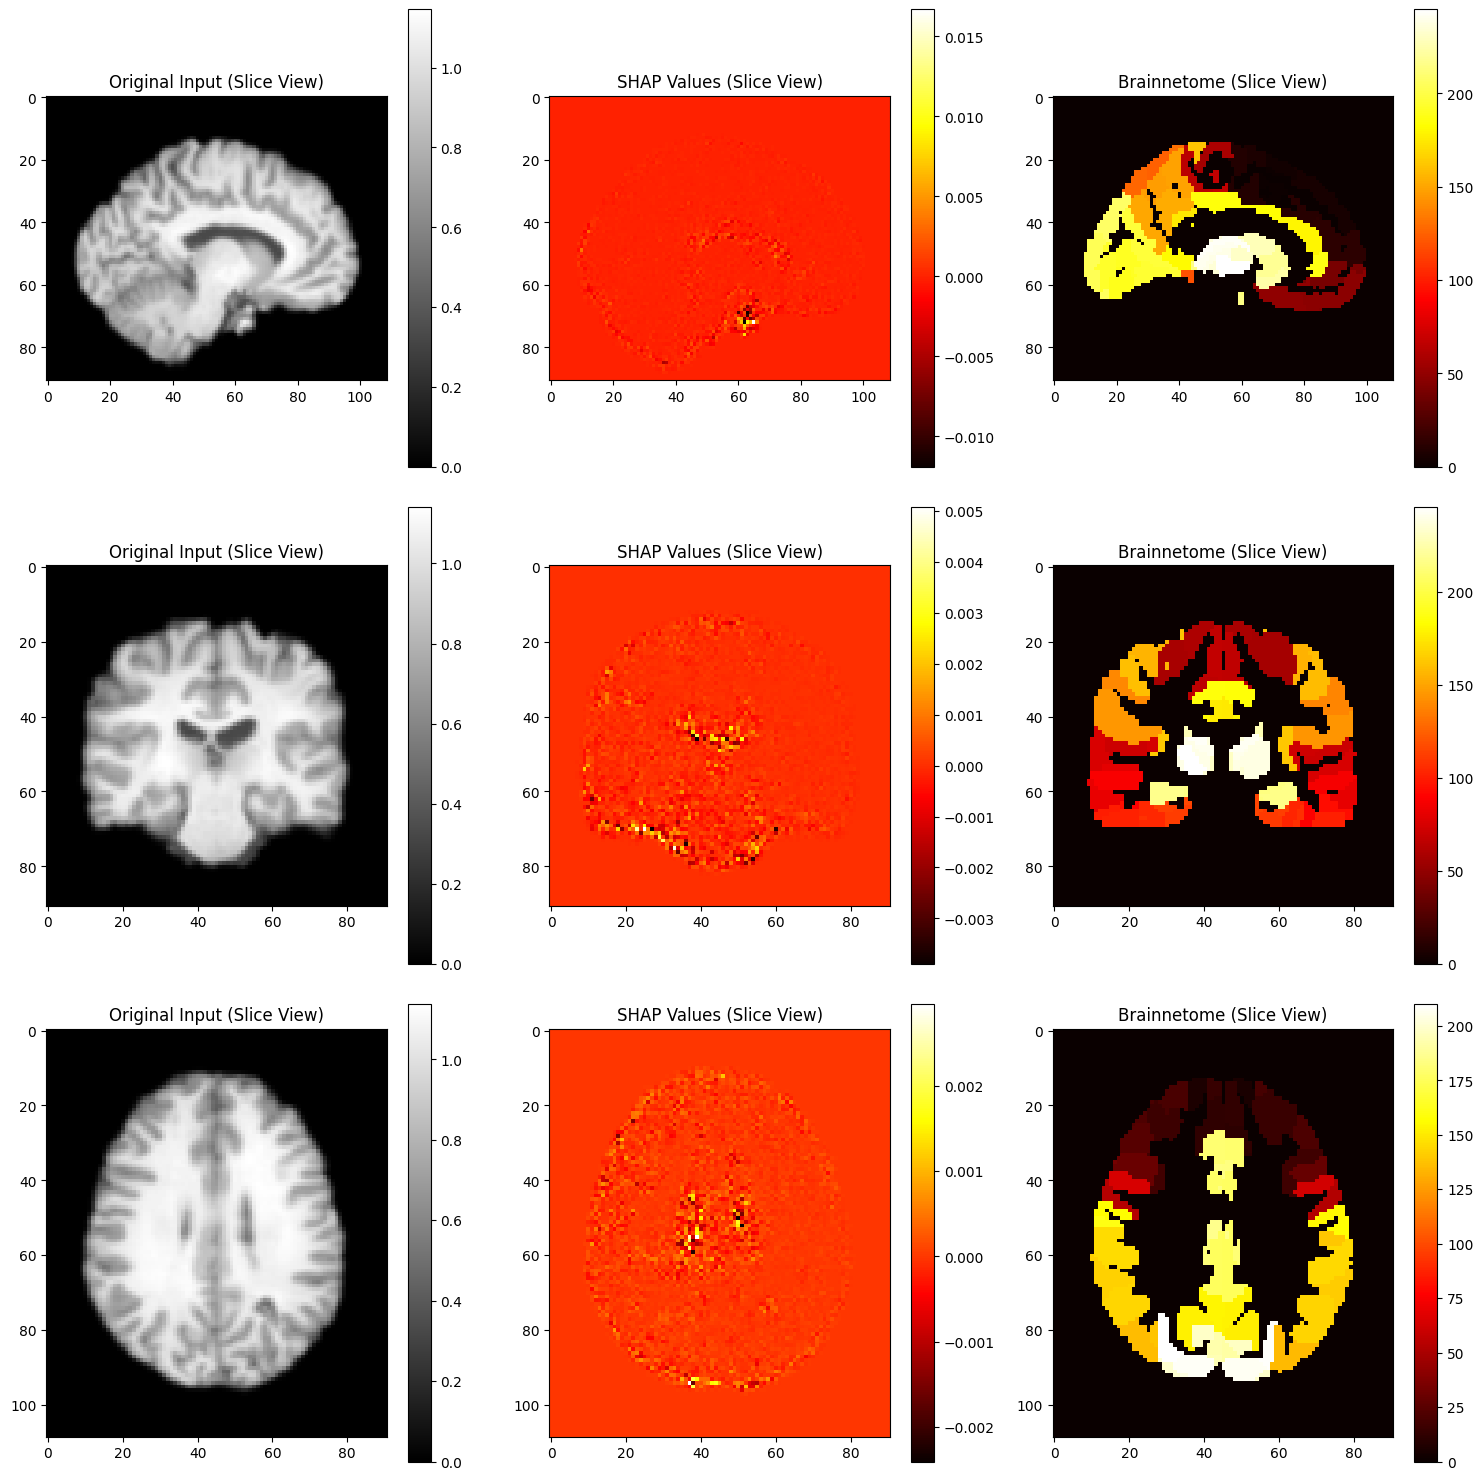

In [17]:
sample_idx = 0
inputs = next(iter(test_loader))
test_sample = inputs[0][sample_idx] if isinstance(inputs, (tuple, list)) else inputs[sample_idx]
shap_values = explanations[sample_idx]

slice_offset = 5
slice_idx = test_sample.shape[1] // 2 + slice_offset

# Titles for each subplot
titles = [
    "Original Input (Slice View)",
    "SHAP Values (Slice View)",
    "Brainnetome (Slice View)",
]

# Prepare the data slices (applying np.rot90)
slices = [
    # Axial view (middle slice + offset)
    [np.rot90(test_sample[0, slice_idx, :, :].cpu().numpy()), 
     np.rot90(shap_values[slice_idx, :, :]), 
     np.rot90(ATLAS[slice_idx, :, :])],

    # Coronal view
    [np.rot90(test_sample[0, :, slice_idx, :].cpu().numpy()), 
     np.rot90(shap_values[:, slice_idx, :]), 
     np.rot90(ATLAS[:, slice_idx, :])],

    # Sagittal view
    [np.rot90(test_sample[0, :, :, slice_idx].cpu().numpy()), 
     np.rot90(shap_values[:, :, slice_idx]), 
     np.rot90(ATLAS[:, :, slice_idx])],
]

# Plotting
plt.figure(figsize=(15, 15))

for i, view_slices in enumerate(slices):
    for j, data in enumerate(view_slices):
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.title(titles[j])
        plt.imshow(data, cmap="gray" if j == 0 else "hot")
        plt.colorbar()

plt.tight_layout()
plt.show()

## ROI contribution

In [ ]:
def locate_top_rois(lst:list, what_percent:int):
    indexed_list = list(enumerate(lst))
    sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1], reverse=True)
    top_20_count = int(len(lst) * what_percent)
    top_20_indices = [index for index, value in sorted_indexed_list[:top_20_count]]
    return top_20_indices

In [20]:
pd.read_csv('/home/neelamlab/ninad/DWI/template/ROI_contributions.csv').drop(columns=['Unnamed: 0'])

,Subject_ID,Sex,ROI,Median
0,201515,0.0,1,-1.391126e-06
1,201515,0.0,2,4.476142e-07
2,201515,0.0,3,-7.196376e-06
3,201515,0.0,4,-9.456967e-06
4,201515,0.0,5,3.580684e-06
...,...,...,...,...
41815,107422,0.0,242,-2.591575e-05
41816,107422,0.0,243,7.505620e-06
41817,107422,0.0,244,1.914870e-04
41818,107422,0.0,245,1.617911e-05
